In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Flatten, Activation, Dense
from sklearn.model_selection import train_test_split

In [3]:
movie = pd.read_csv("IMDB Dataset.csv")

In [4]:
movie

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Data Preprocessing

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('',text)

In [7]:
def preprocess_sent(sen):
    sentence = sen.lower() #lowercase
    sentence = remove_tags(sentence)#remove html tags
    sentence = re.sub('[^a-zA-Z]',' ',sentence)#remove punctuation and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)#remove single char
    sentence = re.sub(r'\s',' ',sentence)#remove multiple spaces
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence

In [8]:
X = []
sentences = list(movie['review'])
for sen in sentences:
    X.append(preprocess_sent(sen))

In [9]:
#converting sentiments to 0 and 1
y = movie['sentiment']
y = np.array(list(map(lambda x:1 if x=='positive' else 0, y)))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

vocab_length = len(word_tokenizer.word_index) + 1 #vocab length -- unique words in tokenizers word index

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen= maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Embedding

1. Transfer Learning: Using pre-trained word embeddings (such as GloVe or Word2Vec embeddings) as initial weights in the embedding layer allows the model to leverage knowledge learned from vast amounts of text data. This is particularly useful when you have a limited amount of training data, as it helps improve the model's performance by transferring knowledge from the pre-trained embeddings.


2. Instead of representing words as sparse one-hot vectors (where each word is represented by a vector with all elements being zero except for one element representing the word), embeddings represent words as dense vectors of fixed size. This dense representation allows the model to generalize better and capture semantic similarities between words.

In [20]:
from numpy import asarray
from numpy import zeros

embeddings_dict = dict()

glove_file = open('glove.6B.100d.txt',encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    dimensions = asarray(records[1:], dtype='float32')
    embeddings_dict[word]=dimensions
glove_file.close()

In [21]:
#Embedding Matrix with 100 columns

embeddings_matrix = zeros((vocab_length, 100))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector


embeddings_matrix.shape

(92394, 100)

### Modelling - Simple Neural Network

In [46]:
model1 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embeddings_matrix], input_length=maxlen, trainable=False)
model1.add(embedding_layer)
model1.add(Flatten()) #flattens the input, dense layer expects flatten input
model1.add(Dense(1, activation='sigmoid')) # 1 neuron for binary classification task, sigmoid outputs between 0 and 1

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 flatten_5 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [47]:
model1.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 1s 3ms/step - loss: 0.5623 - accuracy: 0.7094 - val_loss: 0.5029 - val_accuracy: 0.7635
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4494 - accuracy: 0.7968 - val_loss: 0.5147 - val_accuracy: 0.7546
Epoch 3/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4136 - accuracy: 0.8161 - val_loss: 0.4995 - val_accuracy: 0.7660
Epoch 4/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3898 - accuracy: 0.8284 - val_loss: 0.5109 - val_accuracy: 0.7616
Epoch 5/6
250/250 [==============================] - 1s 3ms/step - loss: 0.3746 - accuracy: 0.8386 - val_loss: 0.5191 - val_accuracy: 0.7564
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3627 - accuracy: 0.8417 - val_loss: 0.5331 - val_accuracy: 0.7548


In [50]:
# Print available keys in the history object
print(model1.history.history.keys())

dict_keys([])


In [51]:
score = model1.evaluate(X_test, y_test, verbose=1)

print("Test score:", score[0])
print("Test accuracy:", score[1])



313/313 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.7500
Test score: 0.5593663454055786
Test accuracy: 0.75


### Modelling - CNN

In [52]:
from keras.layers import Conv1D

In [53]:
model2 = Sequential()
embedding_layer = Embedding(vocab_length,100,weights=[embeddings_matrix], input_length=maxlen, trainable=False)
model2.add(embedding_layer)
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()


model2.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
Epoch 1/6
250/250 [==============================] - 6s 20ms/step - loss: 0.

In [57]:
# Predictions on the Test Set
score = model2.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.3468 - accuracy: 0.8510
Test Score: 0.3468025028705597
Test Accuracy: 0.8510000109672546


### Modelling - LSTM

In [58]:
from keras.layers import LSTM

In [60]:
model3 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embeddings_matrix], input_length=maxlen, trainable=False)
model3.add(embedding_layer)
model3.add(LSTM(128))
model3.add(Dense(1,activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

model3_history = model3.fit(X_train, y_train, batch_size=128, epochs=6, validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
Epoch 1/6
250/250 [==============================] - 65s 236ms/step - loss: 0.5328 - accuracy: 0.7389 - val_loss: 0.5006 - val_accuracy: 0.7619
Epoch 2/6
250/250 [==============================] - 36s 146ms/step - loss: 0.4268 - accuracy: 0.8091 - val_loss: 0.3796 - val_ac

313/313 [==============================] - 7s 21ms/step - loss: 0.3171 - accuracy: 0.8669
Test Score: 0.31714189052581787
Test Accuracy: 0.8669000267982483


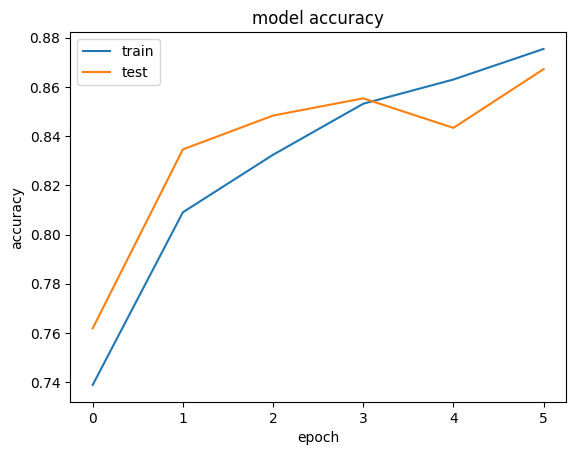

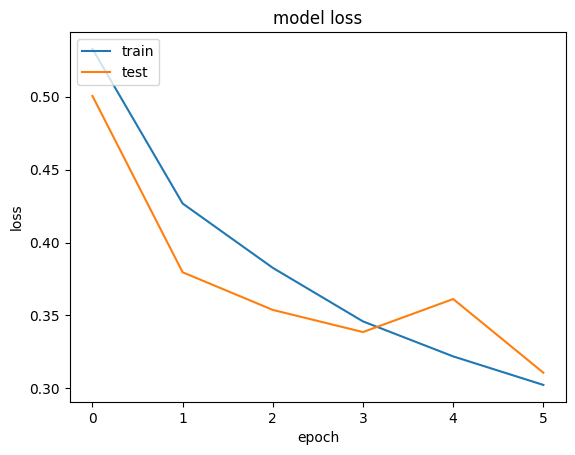

In [62]:
# Predictions on the Test Set
score = model3.evaluate(X_test, y_test, verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
import matplotlib.pyplot as plt
plt.plot(model3_history.history['accuracy'])
plt.plot(model3_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(model3_history.history['loss'])
plt.plot(model3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#### Prediction on unseen reviews

In [65]:
sample_rev = pd.read_csv('IMDb_Unseen_Reviews.csv')

In [66]:
sample_rev

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [67]:
unseen_rev = sample_rev['Review Text']

In [74]:
unseen_rev

0    Intelligent Movie.\nThis movie is obviously al...
1    Extraordinary and thought-provoking.\n'Ex mach...
2    Poor story, only reasonable otherwise.\nIf I h...
3    Had Great Potential.\nThis movie is one of the...
4    Amazing visuals and philosophical concepts!\n\...
5    Worst MCU film ever\n\nFollowing the events of...
Name: Review Text, dtype: object

In [75]:
unseen_processed = []
for review in unseen_rev:
    review = preprocess_sent(review)
    unseen_processed.append(review)

In [76]:
unseen_processed

['intelligent movie  movie obviously allegorical fascinating tale ai  mainly manipulation power  wanting action spectacular cgi  movie aimed people like think  rather passively wait entertained  themes ai  also surveillance  excellent points data us collected phone companies  search engine companies  commercial operating systems makers plot seems simple extremely clever  protagonist playing games  trying stay one step ahead one another  movie perfectly consistent internal logic plays perfectly  go expecting much  however  see people satisfied movie  sets brilliantly  therefore give least       recent movies getting      movie succeeds another recent movie ai  transcendence think called  failed  interesting failure third movie ai spanish movie called eva  also brilliant  eva moving movie philosophical  movies perfect different ways  ai name movie  ava  seems nod title spanish movie  aside  nice stars  appeared ex machina  eva   casting great  course several aspects movie unrealistic oft

In [69]:
unseen_tok = word_tokenizer.texts_to_sequences(unseen_processed)

unseen_pad = pad_sequences(unseen_tok, padding='post', maxlen=maxlen)

In [78]:
#passing tokenised instance to model
unseen_sentiments = model3.predict(unseen_pad)

1/1 [==============================] - 0s 33ms/step


In [79]:
unseen_sentiments

array([[0.9410477 ],
       [0.9938255 ],
       [0.23254378],
       [0.46582907],
       [0.972859  ],
       [0.01024137]], dtype=float32)

In [82]:
sample_rev['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

In [85]:
df_prediction_sentiments = pd.DataFrame(sample_rev['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_rev['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_rev['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_rev['IMDb Rating'], columns = ['IMDb Rating'])
dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)
dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,9.4
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.3
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,4.7
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.7
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1
